In [ ]:
# Dynamic Order Picking Optimization using Deep Reinforcement Learning
# ====================================================================

# Cell 1: Import Libraries and Set Random Seeds
# --------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import random
import time
import seaborn as sns
from matplotlib.animation import FuncAnimation
from IPython.display import display, clear_output
from matplotlib.patches import Rectangle, Circle
import matplotlib.gridspec as gridspec

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

In [ ]:

# Cell 2: Warehouse Environment Class
# ----------------------------------
class WarehouseEnvironment:
    """
    2D Warehouse Environment for Order Picking
    - Grid represents a 10x10 warehouse space
    - Includes storage racks, agent, and target items
    """
    def __init__(self, grid_size=10, num_racks=10, num_targets=5):
        self.grid_size = grid_size
        self.grid = np.zeros((grid_size, grid_size), dtype=int)

        # Setup obstacles (storage racks)
        self.setup_racks(num_racks)

        # Setup targets
        self.targets = self.generate_targets(num_targets)

        # Agent initial position
        self.agent_pos = self.get_random_empty_cell()

        # Tracking picked items
        self.picked_items = set()

        # Track agent path and actions for visualization
        self.path_history = [self.agent_pos]
        self.action_history = []

    def setup_racks(self, num_racks):
        """
        Randomly place storage racks on the grid
        Racks are represented by value 1
        """
        for _ in range(num_racks):
            while True:
                x, y = np.random.randint(0, self.grid_size, 2)
                if self.grid[x, y] == 0:
                    self.grid[x, y] = 1
                    break

    def generate_targets(self, num_targets):
        """
        Generate random target item locations
        Ensures targets are not on racks or overlapping
        """
        targets = set()
        while len(targets) < num_targets:
            x, y = np.random.randint(0, self.grid_size, 2)
            if self.grid[x, y] == 0:
                targets.add((x, y))
        return list(targets)

    def get_random_empty_cell(self):
        """
        Find a random empty cell for agent placement
        """
        while True:
            x, y = np.random.randint(0, self.grid_size, 2)
            if self.grid[x, y] == 0:
                return (x, y)

    def reset(self):
        """
        Reset the environment for a new episode
        """
        # Reset agent position
        self.agent_pos = self.get_random_empty_cell()

        # Reset picked items
        self.picked_items = set()

        # Reset path history
        self.path_history = [self.agent_pos]
        self.action_history = []

        return self.get_state()

    def get_state(self):
        """
        Get current state representation
        """
        # Flatten grid with agent and target information
        state = self.grid.copy().flatten()

        # Add agent position information
        agent_x, agent_y = self.agent_pos
        state = np.concatenate([
            state,
            [agent_x / self.grid_size, agent_y / self.grid_size]
        ])

        # Add target status (picked or not)
        for target in self.targets:
            state = np.concatenate([
                state,
                [1 if target in self.picked_items else 0]
            ])

        return state

    def step(self, action):
        """
        Execute an action and return next state, reward, done flag
        Actions: 0-Up, 1-Right, 2-Down, 3-Left
        """
        x, y = self.agent_pos

        # Store action for visualization
        self.action_history.append(action)

        # Movement actions
        if action == 0 and x > 0:  # Up
            new_x, new_y = x-1, y
        elif action == 1 and y < self.grid_size-1:  # Right
            new_x, new_y = x, y+1
        elif action == 2 and x < self.grid_size-1:  # Down
            new_x, new_y = x+1, y
        elif action == 3 and y > 0:  # Left
            new_x, new_y = x, y-1
        else:
            new_x, new_y = x, y

        # Check for obstacle
        if self.grid[new_x, new_y] == 0:
            self.agent_pos = (new_x, new_y)

        # Add to path history
        self.path_history.append(self.agent_pos)

        # Check for item pickup
        reward = -1  # Small negative reward for each step
        done = False

        if self.agent_pos in self.targets and self.agent_pos not in self.picked_items:
            self.picked_items.add(self.agent_pos)
            reward = 10  # Significant reward for picking an item

        # Check if all items picked
        if len(self.picked_items) == len(self.targets):
            done = True
            reward = 100  # Large reward for completing the task

        return self.get_state(), reward, done

    def get_travel_distance(self):
        """
        Calculate the total travel distance of the agent
        """
        distance = 0
        for i in range(1, len(self.path_history)):
            prev_x, prev_y = self.path_history[i-1]
            curr_x, curr_y = self.path_history[i]
            distance += abs(curr_x - prev_x) + abs(curr_y - prev_y) # Manhatten Distance
        return distance

    def render(self, ax=None, show_path=True):
        """
        Render the current state of the environment
        """
        if ax is None:
            fig, ax = plt.subplots(figsize=(8, 8))
            show_plot = True
        else:
            show_plot = False

        # Clear the axis
        ax.clear()

        # Create a grid
        ax.set_xlim(-0.5, self.grid_size - 0.5)
        ax.set_ylim(-0.5, self.grid_size - 0.5)
        ax.set_xticks(np.arange(-0.5, self.grid_size, 1), minor=True)
        ax.set_yticks(np.arange(-0.5, self.grid_size, 1), minor=True)
        ax.grid(which='minor', color='gray', linestyle='-', linewidth=1)

        # Plot obstacles (racks)
        for i in range(self.grid_size):
            for j in range(self.grid_size):
                if self.grid[i, j] == 1:
                    ax.add_patch(Rectangle((j-0.5, i-0.5), 1, 1, fill=True, color='gray', alpha=0.7))

        # Plot targets
        for i, target in enumerate(self.targets):
            x, y = target
            if target in self.picked_items:
                ax.add_patch(Rectangle((y-0.5, x-0.5), 1, 1, fill=True, color='lightgreen', alpha=0.5))
                ax.text(y, x, f'T{i}', ha='center', va='center', color='green', fontweight='bold')
            else:
                ax.add_patch(Rectangle((y-0.5, x-0.5), 1, 1, fill=True, color='lightcoral', alpha=0.5))
                ax.text(y, x, f'T{i}', ha='center', va='center', color='red', fontweight='bold')

        # Plot agent
        agent_x, agent_y = self.agent_pos
        ax.add_patch(Circle((agent_y, agent_x), 0.3, fill=True, color='blue', alpha=0.7))
        ax.text(agent_y, agent_x, 'A', ha='center', va='center', color='white', fontweight='bold')

        # Plot path if needed
        if show_path and len(self.path_history) > 1:
            path_x = [p[1] for p in self.path_history]
            path_y = [p[0] for p in self.path_history]
            ax.plot(path_x, path_y, 'b-', alpha=0.4)

        # Set the axis labels
        ax.set_xlabel('Column')
        ax.set_ylabel('Row')
        ax.set_title('Warehouse Environment')

        if show_plot:
            plt.tight_layout()
            plt.show()

        return ax

In [ ]:
# Cell 3: Agent Implementation - Rule-Based and DQN
# -----------------------------------------------
class RuleBased:
    """
    Rule-Based Agent using greedy nearest-item strategy
    """
    def select_action(self, env):
        """
        Always move towards the nearest unpicked target
        """
        x, y = env.agent_pos

        # Find nearest unpicked target
        nearest_target = None
        min_dist = float('inf')

        for target in env.targets:
            if target not in env.picked_items:
                dist = abs(target[0] - x) + abs(target[1] - y)
                if dist < min_dist:
                    min_dist = dist
                    nearest_target = target

        if nearest_target is None:
            return np.random.randint(4)  # Random action if all picked

        # Determine direction to move
        target_x, target_y = nearest_target

        # Prioritize movement based on which dimension has the larger difference
        if abs(target_x - x) > abs(target_y - y):
            if target_x < x:
                return 0  # Move Up
            elif target_x > x:
                return 2  # Move Down
        else:
            if target_y < y:
                return 3  # Move Left
            elif target_y > y:
                return 1  # Move Right

        return np.random.randint(4)  # Fallback random action

class DeepQNetwork(nn.Module):
    """
    Neural Network for Deep Q-Learning
    """
    def __init__(self, state_size, action_size):
        super(DeepQNetwork, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(state_size, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, action_size)
        )

    def forward(self, x):
        return self.network(x)

class DQNAgent:
    """
    Deep Q-Learning Agent
    """
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size

        # Neural network and optimizer
        self.model = DeepQNetwork(state_size, action_size)
        self.optimizer = optim.Adam(self.model.parameters())
        self.loss_fn = nn.MSELoss()

        # Hyperparameters
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.gamma = 0.99  # Discount factor

        # Replay memory
        self.memory = []
        self.batch_size = 32
        self.memory_size = 2000

        # Training metrics
        self.loss_history = []

    def select_action(self, state):
        """
        Epsilon-greedy action selection
        """
        if np.random.rand() <= self.epsilon:
            return np.random.randint(self.action_size)

        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            q_values = self.model(state_tensor)
        return torch.argmax(q_values).item()

    def remember(self, state, action, reward, next_state, done):
        """
        Store experience in replay memory
        """
        if len(self.memory) > self.memory_size:
            self.memory.pop(0)
        self.memory.append((state, action, reward, next_state, done))

    def replay(self):
        """
        Experience replay for learning
        """
        if len(self.memory) < self.batch_size:
            return 0  # Return 0 loss if no training occurred

        # Sample batch from memory
        batch = random.sample(self.memory, self.batch_size)

        # Prepare batch tensors
        states = torch.FloatTensor([exp[0] for exp in batch])
        actions = torch.LongTensor([exp[1] for exp in batch])
        rewards = torch.FloatTensor([exp[2] for exp in batch])
        next_states = torch.FloatTensor([exp[3] for exp in batch])
        dones = torch.FloatTensor([exp[4] for exp in batch])

        # Compute Q-values
        current_q_values = self.model(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        next_q_values = self.model(next_states).max(1)[0]
        target_q_values = rewards + (1 - dones) * self.gamma * next_q_values

        # Compute loss
        loss = self.loss_fn(current_q_values, target_q_values.detach())

        # Store loss history
        self.loss_history.append(loss.item())

        # Optimize
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Decay exploration
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

        return loss.item()

In [ ]:
# Cell 4: Simulation Functions
# -------------------------
def run_simulation(agent_type, env, num_episodes=1000, render_interval=None):
    """
    Run simulation for either Rule-Based or DQN Agent

    Parameters:
    - agent_type: 'rule_based' or 'dqn'
    - env: WarehouseEnvironment instance
    - num_episodes: Number of episodes to run
    - render_interval: If not None, render environment every N episodes

    Returns:
    - Metrics: steps, success, rewards, distances, orders_completed, time_taken, loss_history
    """
    steps_per_episode = []
    success_rates = []
    rewards_per_episode = []
    distances_per_episode = []
    orders_completed_per_episode = []
    time_taken_per_episode = []
    loss_history = []

    # Create rule-based agent or DQN agent
    if agent_type == 'rule_based':
        agent = RuleBased()
    else:  # 'dqn'
        init_state = env.reset()
        agent = DQNAgent(len(init_state), 4)

    for episode in range(num_episodes):
        state = env.reset()
        total_steps = 0
        total_reward = 0
        done = False
        episode_start_time = time.time()
        episode_loss = []

        # Render initial state if needed
        if render_interval and episode % render_interval == 0:
            fig, ax = plt.subplots(figsize=(8, 8))
            env.render(ax)
            plt.title(f"{agent_type.upper()} Agent - Episode {episode} (Start)")
            plt.show()
            plt.close()

        while not done:
            # Select and execute action
            if agent_type == 'rule_based':
                action = agent.select_action(env)
            else:
                action = agent.select_action(state)

            # Step in environment
            next_state, reward, done = env.step(action)
            total_reward += reward

            # For DQN, store experience and replay
            if agent_type == 'dqn':
                agent.remember(state, action, reward, next_state, done)
                loss = agent.replay()
                if loss > 0:
                    episode_loss.append(loss)

            state = next_state
            total_steps += 1

            # Prevent infinite loops
            if total_steps > 200:
                break

        # Record episode metrics
        steps_per_episode.append(total_steps)
        success_rates.append(1 if total_steps < 200 and len(env.picked_items) == len(env.targets) else 0)
        rewards_per_episode.append(total_reward)
        distances_per_episode.append(env.get_travel_distance())
        orders_completed_per_episode.append(len(env.picked_items))
        time_taken_per_episode.append(time.time() - episode_start_time)

        if agent_type == 'dqn' and episode_loss:
            loss_history.append(np.mean(episode_loss))
        elif agent_type == 'dqn':
            loss_history.append(0)

        # Render final state if needed
        if render_interval and episode % render_interval == 0:
            fig, ax = plt.subplots(figsize=(8, 8))
            env.render(ax)
            plt.title(f"{agent_type.upper()} Agent - Episode {episode} (End)")
            plt.show()
            plt.close()

            # Print episode summary
            print(f"Episode: {episode}")
            print(f"Steps: {total_steps}")
            print(f"Success: {'Yes' if success_rates[-1] == 1 else 'No'}")
            print(f"Reward: {total_reward}")
            print(f"Items Picked: {len(env.picked_items)}/{len(env.targets)}")
            print(f"Distance: {env.get_travel_distance()}")
            print(f"Time: {time_taken_per_episode[-1]:.2f}s")
            if agent_type == 'dqn' and episode_loss:
                print(f"Mean Loss: {np.mean(episode_loss):.4f}")
            print("-" * 40)

        # Progress update every 100 episodes
        if episode % 100 == 0 and episode > 0:
            avg_success = np.mean(success_rates[-100:]) * 100
            avg_steps = np.mean(steps_per_episode[-100:])
            print(f"Episode: {episode}/{num_episodes}, Success rate: {avg_success:.2f}%, Avg Steps: {avg_steps:.2f}")

    # Compile metrics
    metrics = {
        'steps': steps_per_episode,
        'success': success_rates,
        'rewards': rewards_per_episode,
        'distances': distances_per_episode,
        'orders_completed': orders_completed_per_episode,
        'time_taken': time_taken_per_episode,
        'loss_history': loss_history if agent_type == 'dqn' else []
    }

    return metrics

In [ ]:
# Cell 5: Visualization Functions
# -----------------------------
def plot_metrics_comparison(rule_based_metrics, dqn_metrics):
    """
    Create comprehensive comparative visualizations between rule-based and DQN agents
    """
    # Setup the figure
    fig = plt.figure(figsize=(20, 15))
    gs = gridspec.GridSpec(3, 3, figure=fig)

    # 1. Steps per Episode
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(rule_based_metrics['steps'], label='Rule-Based Agent', alpha=0.7, color='blue')
    ax1.plot(dqn_metrics['steps'], label='DQN Agent', alpha=0.7, color='red')
    ax1.set_title('Steps per Episode', fontsize=12)
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Number of Steps')
    ax1.legend()
    ax1.grid(alpha=0.3)

    # 2. Cumulative Success Rate
    ax2 = fig.add_subplot(gs[0, 1])
    rule_based_cumsum = np.cumsum(rule_based_metrics['success']) / (np.arange(len(rule_based_metrics['success'])) + 1)
    dqn_cumsum = np.cumsum(dqn_metrics['success']) / (np.arange(len(dqn_metrics['success'])) + 1)
    ax2.plot(rule_based_cumsum, label='Rule-Based Agent', color='blue')
    ax2.plot(dqn_cumsum, label='DQN Agent', color='red')
    ax2.set_title('Cumulative Success Rate', fontsize=12)
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Success Rate')
    ax2.legend()
    ax2.grid(alpha=0.3)

    # 3. Orders Completed per Episode
    ax3 = fig.add_subplot(gs[0, 2])
    ax3.plot(rule_based_metrics['orders_completed'], label='Rule-Based Agent', alpha=0.7, color='blue')
    ax3.plot(dqn_metrics['orders_completed'], label='DQN Agent', alpha=0.7, color='red')
    ax3.set_title('Orders Completed per Episode', fontsize=12)
    ax3.set_xlabel('Episode')
    ax3.set_ylabel('Orders Completed')
    ax3.legend()
    ax3.grid(alpha=0.3)

    # 4. Time Taken per Episode
    ax4 = fig.add_subplot(gs[1, 0])
    ax4.plot(rule_based_metrics['time_taken'], label='Rule-Based Agent', alpha=0.7, color='blue')
    ax4.plot(dqn_metrics['time_taken'], label='DQN Agent', alpha=0.7, color='red')
    ax4.set_title('Time Taken per Episode', fontsize=12)
    ax4.set_xlabel('Episode')
    ax4.set_ylabel('Time (seconds)')
    ax4.legend()
    ax4.grid(alpha=0.3)

    # 5. Reward per Episode
    ax5 = fig.add_subplot(gs[1, 1])
    ax5.plot(rule_based_metrics['rewards'], label='Rule-Based Agent', alpha=0.7, color='blue')
    ax5.plot(dqn_metrics['rewards'], label='DQN Agent', alpha=0.7, color='red')
    ax5.set_title('Reward per Episode', fontsize=12)
    ax5.set_xlabel('Episode')
    ax5.set_ylabel('Total Reward')
    ax5.legend()
    ax5.grid(alpha=0.3)

    # 6. Distance per Episode
    ax6 = fig.add_subplot(gs[1, 2])
    ax6.plot(rule_based_metrics['distances'], label='Rule-Based Agent', alpha=0.7, color='blue')
    ax6.plot(dqn_metrics['distances'], label='DQN Agent', alpha=0.7, color='red')
    ax6.set_title('Distance Traveled per Episode', fontsize=12)
    ax6.set_xlabel('Episode')
    ax6.set_ylabel('Distance')
    ax6.legend()
    ax6.grid(alpha=0.3)

    # 7. DQN Loss History
    ax7 = fig.add_subplot(gs[2, 0])
    if len(dqn_metrics['loss_history']) > 0:
        ax7.plot(dqn_metrics['loss_history'], color='purple')
        ax7.set_title('DQN Loss History', fontsize=12)
        ax7.set_xlabel('Episode')
        ax7.set_ylabel('Loss')
        ax7.grid(alpha=0.3)
    else:
        ax7.text(0.5, 0.5, 'No loss data available', ha='center', va='center')
        ax7.set_title('DQN Loss History', fontsize=12)

    # 8. Distribution of Steps (Histogram)
    ax8 = fig.add_subplot(gs[2, 1])
    ax8.hist(rule_based_metrics['steps'], bins=20, alpha=0.5, label='Rule-Based Agent', color='blue')
    ax8.hist(dqn_metrics['steps'], bins=20, alpha=0.5, label='DQN Agent', color='red')
    ax8.set_title('Distribution of Steps per Episode', fontsize=12)
    ax8.set_xlabel('Number of Steps')
    ax8.set_ylabel('Frequency')
    ax8.legend()
    ax8.grid(alpha=0.3)

    # 9. Average Order Completion Time (AOCT)
    ax9 = fig.add_subplot(gs[2, 2])
    rule_based_window = np.convolve(rule_based_metrics['steps'], np.ones(100)/100, mode='valid')
    dqn_window = np.convolve(dqn_metrics['steps'], np.ones(100)/100, mode='valid')
    ax9.plot(rule_based_window, label='Rule-Based Agent', color='blue')
    ax9.plot(dqn_window, label='DQN Agent', color='red')
    ax9.set_title('Moving Average Order Completion Time (AOCT)', fontsize=12)
    ax9.set_xlabel('Episode')
    ax9.set_ylabel('Average Steps (Window=100)')
    ax9.legend()
    ax9.grid(alpha=0.3)

    plt.tight_layout()
    return fig

def create_warehouse_animation(env, agent, agent_type, max_steps=200):
    """
    Create an animation of the agent navigating the warehouse

    Parameters:
    - env: WarehouseEnvironment instance
    - agent: RuleBased or DQNAgent instance
    - agent_type: 'rule_based' or 'dqn'
    - max_steps: Maximum number of steps to simulate

    Returns:
    - Animation figure
    """
    # Reset environment
    state = env.reset()

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(10, 10))

    # Initial render
    env.render(ax)

    # Counter for tracking steps and metrics
    step_counter = 0
    done = False
    total_reward = 0
    metrics_text = plt.text(0.02, 0.98, '', transform=ax.transAxes,
                           verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

    def update(frame):
        nonlocal state, step_counter, done, total_reward

        if step_counter < max_steps and not done:
            # Select action
            if agent_type == 'rule_based':
                action = agent.select_action(env)
            else:
                action = agent.select_action(state)

            # Execute action
            next_state, reward, done = env.step(action)
            state = next_state
            total_reward += reward
            step_counter += 1

            # Update the visualization
            env.render(ax, show_path=True)

            # Update metrics text
            metrics_text.set_text(f'Step: {step_counter}\n'
                                 f'Reward: {total_reward}\n'
                                 f'Items Picked: {len(env.picked_items)}/{len(env.targets)}\n'
                                 f'Done: {done}')

        return ax,

    # Create animation
    anim = FuncAnimation(fig, update, frames=max_steps, interval=200, blit=False, repeat=False)

    plt.close()  # Prevent duplicate display
    return anim, fig


In [ ]:
import pandas as pd
# Cell 6: Simulation Analysis Functions
# ----------------------------------
def analyze_performance(rule_based_metrics, dqn_metrics):
    """
    Display statistical comparison of both agents' performance
    """
    # Compute key statistics for both agents
    rule_based_stats = {
        'avg_steps': np.mean(rule_based_metrics['steps']),
        'success_rate': np.mean(rule_based_metrics['success']) * 100,
        'avg_orders': np.mean(rule_based_metrics['orders_completed']),
        'avg_time': np.mean(rule_based_metrics['time_taken']),
        'avg_reward': np.mean(rule_based_metrics['rewards']),
        'avg_distance': np.mean(rule_based_metrics['distances']),
        'median_steps': np.median(rule_based_metrics['steps']),
        'min_steps': np.min(rule_based_metrics['steps']),
        'max_steps': np.max(rule_based_metrics['steps'])
    }

    dqn_stats = {
        'avg_steps': np.mean(dqn_metrics['steps']),
        'success_rate': np.mean(dqn_metrics['success']) * 100,
        'avg_orders': np.mean(dqn_metrics['orders_completed']),
        'avg_time': np.mean(dqn_metrics['time_taken']),
        'avg_reward': np.mean(dqn_metrics['rewards']),
        'avg_distance': np.mean(dqn_metrics['distances']),
        'median_steps': np.median(dqn_metrics['steps']),
        'min_steps': np.min(dqn_metrics['steps']),
        'max_steps': np.max(dqn_metrics['steps'])
    }

    # Create a comparison table
    print("\n" + "="*50)
    print("Performance Comparison - Rule-Based vs DQN Agent")
    print("="*50)

    metrics = [
        ('Average Steps', 'avg_steps', ':.2f'),
        ('Success Rate (%)', 'success_rate', ':.2f'),
        ('Average Orders Completed', 'avg_orders', ':.2f'),
        ('Average Reward', 'avg_reward', ':.2f'),
        ('Average Distance', 'avg_distance', ':.2f'),
        ('Median Steps', 'median_steps', ':.1f'),
        ('Min Steps', 'min_steps', ':d'),
        ('Max Steps', 'max_steps', ':d'),
        ('Average Time (s)', 'avg_time', ':.4f')
    ]

    # for label, key, format_str in metrics:
    #     # Convert values to floats before formatting
    #     rule_based_value = float(rule_based_stats[key])
    #     dqn_value = float(dqn_stats[key])

    #     print(f"{label:<25} | {rule_based_value:{format_str}} | {dqn_value:{format_str}} | " +
    #           f"{(dqn_value - rule_based_value):{format_str}} | " +
    #           f"{((dqn_value / rule_based_value) - 1)*100:+.2f}%")

    # print("="*50)

    # Create a DataFrame for the comparison table
    data = []
    for label, key, format_str in metrics:
        rule_based_value = rule_based_stats[key]
        dqn_value = dqn_stats[key]
        diff = dqn_value - rule_based_value
        percent_change = ((dqn_value / rule_based_value) - 1) * 100

        data.append([label, rule_based_value, dqn_value, diff, f"{percent_change:+.2f}%"])

    df = pd.DataFrame(data, columns=['Metric', 'Rule-Based', 'DQN', 'Difference', '% Change'])
    df = df.set_index('Metric')  # Set 'Metric' column as index

    # Print the DataFrame
    print("\n" + "=" * 50)
    print("Performance Comparison - Rule-Based vs DQN Agent")
    print("=" * 50)
    print(df)  # Print the DataFrame for formatted output
    print("=" * 50)

    # Analyze what percentage of episodes reached the goal
    rule_goal_rate = np.sum([1 for o in rule_based_metrics['orders_completed'] if o == len(env.targets)]) / len(rule_based_metrics['orders_completed']) * 100
    dqn_goal_rate = np.sum([1 for o in dqn_metrics['orders_completed'] if o == len(env.targets)]) / len(dqn_metrics['orders_completed']) * 100

    print(f"\nPercentage of episodes where all items were picked:")
    print(f"Rule-Based Agent: {rule_goal_rate:.2f}%")
    print(f"DQN Agent: {dqn_goal_rate:.2f}%")
    print(f"Difference: {dqn_goal_rate - rule_goal_rate:+.2f}%")

    # Analyze efficiency (reward per step)
    rule_efficiency = np.mean([r/s for r, s in zip(rule_based_metrics['rewards'], rule_based_metrics['steps'])])
    dqn_efficiency = np.mean([r/s for r, s in zip(dqn_metrics['rewards'], dqn_metrics['steps'])])

    print(f"\nEfficiency (reward per step):")
    print(f"Rule-Based Agent: {rule_efficiency:.4f}")
    print(f"DQN Agent: {dqn_efficiency:.4f}")
    print(f"Difference: {dqn_efficiency - rule_efficiency:+.4f}")

    return rule_based_stats, dqn_stats

def visualize_specific_episode(env, agent, agent_type, max_steps=200):
    """
    Visualize a specific episode step by step

    Parameters:
    - env: WarehouseEnvironment instance
    - agent: RuleBased or DQNAgent instance
    - agent_type: 'rule_based' or 'dqn'
    - max_steps: Maximum number of steps to simulate

    Returns:
    - None (displays visualization)
    """
    # Reset environment
    state = env.reset()

    # Step through the environment
    done = False
    step_count = 0
    total_reward = 0

    while not done and step_count < max_steps:
        # Render current state
        plt.figure(figsize=(8, 8))
        env.render()
        plt.title(f"{agent_type.upper()} Agent - Step {step_count}\n" +
                  f"Reward: {total_reward}, Items: {len(env.picked_items)}/{len(env.targets)}")
        plt.show()

        # Get action
        if agent_type == 'rule_based':
            action = agent.select_action(env)
        else:
            action = agent.select_action(state)

        # Execute action
        next_state, reward, done = env.step(action)
        state = next_state
        total_reward += reward
        step_count += 1

        # Display action taken
        action_names = ['Up', 'Right', 'Down', 'Left']
        print(f"Step {step_count}: Action = {action_names[action]}, Reward = {reward}")

        # Pause for visualization
        time.sleep(0.5)

    # Final state
    plt.figure(figsize=(8, 8))
    env.render()
    plt.title(f"{agent_type.upper()} Agent - Final State (Step {step_count})\n" +
              f"Reward: {total_reward}, Items: {len(env.picked_items)}/{len(env.targets)}")
    plt.show()

    print(f"\nEpisode Summary:")
    print(f"Total Steps: {step_count}")
    print(f"Total Reward: {total_reward}")
    print(f"Items Picked: {len(env.picked_items)}/{len(env.targets)}")
    print(f"Success: {'Yes' if done else 'No'}")


In [ ]:
# # Cell 7: Main Function and Program Execution
# # -----------------------------------------
# def main():
#     """
#     Main simulation and visualization
#     """
#     # Set random seeds for reproducibility
#     np.random.seed(42)
#     torch.manual_seed(42)
#     random.seed(42)

#     # Create environment
#     env = WarehouseEnvironment(grid_size=10, num_racks=10, num_targets=5)

#     # Display the initial environment
#     plt.figure(figsize=(8, 8))
#     env.render()
#     plt.title("Initial Warehouse Environment")
#     plt.show()

#     # Run simulations
#     print("Running Rule-Based Agent simulation...")
#     rule_based_metrics = run_simulation('rule_based', env, num_episodes=1000, render_interval=None)

#     print("Running DQN Agent simulation...")
#     dqn_metrics = run_simulation('dqn', env, num_episodes=1000, render_interval=None)

#     # Analyze performance
#     rule_based_stats, dqn_stats = analyze_performance(rule_based_metrics, dqn_metrics)

#     # Plot comparative metrics
#     print("\nGenerating comparative visualizations...")
#     comparison_fig = plot_metrics_comparison(rule_based_metrics, dqn_metrics)
#     plt.show()

#     # Create an agent for animation
#     print("\nCreating animation of the trained agents...")
#     # Rule-based agent
#     rule_based_agent = RuleBased()
#     rule_anim, rule_fig = create_warehouse_animation(env, rule_based_agent, 'rule_based', max_steps=100)
#     display(rule_fig)
#     print("Rule-Based Agent Animation Ready")

#     # DQN agent
#     init_state = env.reset()
#     dqn_agent = DQNAgent(len(init_state), 4)
#     # Load trained weights if available or train a quick model
#     # (assuming we have a trained model from prior simulation)
#     dqn_anim, dqn_fig = create_warehouse_animation(env, dqn_agent, 'dqn', max_steps=100)
#     display(dqn_fig)
#     print("DQN Agent Animation Ready")

#     # Final statistics
#     print("\nFinal Statistics:")
#     print("\nRule-Based Agent:")
#     print(f"Average Steps: {rule_based_stats['avg_steps']:.2f}")
#     print(f"Success Rate: {rule_based_stats['success_rate']:.2f}%")
#     print(f"Average Orders Completed: {rule_based_stats['avg_orders']:.2f}")

#     print("\nDQN Agent:")
#     print(f"Average Steps: {dqn_stats['avg_steps']:.2f}")
#     print(f"Success Rate: {dqn_stats['success_rate']:.2f}%")
#     print(f"Average Orders Completed: {dqn_stats['avg_orders']:.2f}")

In [ ]:
# Cell 8: Extended Analysis and Visualization Functions
# --------------------------------------------------
def compare_with_varying_parameters(param_name, param_values, num_episodes=200):
    """
    Compare performance across varying environment parameters

    Parameters:
    - param_name: Name of parameter to vary ('num_racks', 'num_targets', 'grid_size')
    - param_values: List of values to test
    - num_episodes: Number of episodes per configuration

    Returns:
    - Comparison visualization
    """
    rule_based_results = []
    dqn_results = []

    for value in param_values:
        print(f"Testing {param_name}={value}...")

        # Create environment with specified parameter
        if param_name == 'num_racks':
            env = WarehouseEnvironment(num_racks=value)
        elif param_name == 'num_targets':
            env = WarehouseEnvironment(num_targets=value)
        elif param_name == 'grid_size':
            env = WarehouseEnvironment(grid_size=value)
        else:
            raise ValueError(f"Unknown parameter: {param_name}")

        # Run simulations
        rule_based_metrics = run_simulation('rule_based', env, num_episodes=num_episodes)
        dqn_metrics = run_simulation('dqn', env, num_episodes=num_episodes)

        # Store results
        rule_based_results.append({
            'success_rate': np.mean(rule_based_metrics['success']) * 100,
            'avg_steps': np.mean(rule_based_metrics['steps']),
            'avg_reward': np.mean(rule_based_metrics['rewards'])
        })

        dqn_results.append({
            'success_rate': np.mean(dqn_metrics['success']) * 100,
            'avg_steps': np.mean(dqn_metrics['steps']),
            'avg_reward': np.mean(dqn_metrics['rewards'])
        })

    # Create visualization
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Success Rate
    axes[0].plot(param_values, [r['success_rate'] for r in rule_based_results], 'o-', label='Rule-Based')
    axes[0].plot(param_values, [r['success_rate'] for r in dqn_results], 's-', label='DQN')
    axes[0].set_title(f'Success Rate vs {param_name}')
    axes[0].set_xlabel(param_name)
    axes[0].set_ylabel('Success Rate (%)')
    axes[0].legend()
    axes[0].grid(alpha=0.3)

    # Average Steps
    axes[1].plot(param_values, [r['avg_steps'] for r in rule_based_results], 'o-', label='Rule-Based')
    axes[1].plot(param_values, [r['avg_steps'] for r in dqn_results], 's-', label='DQN')
    axes[1].set_title(f'Average Steps vs {param_name}')
    axes[1].set_xlabel(param_name)
    axes[1].set_ylabel('Average Steps')
    axes[1].legend()
    axes[1].grid(alpha=0.3)

    # Average Reward
    axes[2].plot(param_values, [r['avg_reward'] for r in rule_based_results], 'o-', label='Rule-Based')
    axes[2].plot(param_values, [r['avg_reward'] for r in dqn_results], 's-', label='DQN')
    axes[2].set_title(f'Average Reward vs {param_name}')
    axes[2].set_xlabel(param_name)
    axes[2].set_ylabel('Average Reward')
    axes[2].legend()
    axes[2].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    return rule_based_results, dqn_results

def visualize_warehouse_heatmap(env, agent, agent_type, num_episodes=50, max_steps=200):
    """
    Generate a heatmap of agent positions across multiple episodes

    Parameters:
    - env: WarehouseEnvironment instance
    - agent: RuleBased or DQNAgent instance
    - agent_type: 'rule_based' or 'dqn'
    - num_episodes: Number of episodes to collect data from
    - max_steps: Maximum steps per episode

    Returns:
    - Heatmap visualization
    """
    # Initialize heatmap data
    heatmap_data = np.zeros((env.grid_size, env.grid_size))

    for episode in range(num_episodes):
        print(f"\rGenerating heatmap: Episode {episode+1}/{num_episodes}", end="")

        state = env.reset()
        done = False
        step_count = 0

        # Track agent positions
        while not done and step_count < max_steps:
            if agent_type == 'rule_based':
                action = agent.select_action(env)
            else:
                action = agent.select_action(state)

            next_state, reward, done = env.step(action)
            state = next_state
            step_count += 1

            # Update heatmap
            x, y = env.agent_pos
            heatmap_data[x, y] += 1

    print("\nHeatmap generation complete.")

    # Create visualization
    plt.figure(figsize=(10, 8))

    # Plot heatmap
    sns.heatmap(heatmap_data, cmap='viridis', annot=False, fmt=".1f", cbar=True)

    # Overlay grid layout
    for i in range(env.grid_size):
        for j in range(env.grid_size):
            if env.grid[i, j] == 1:  # Rack
                plt.scatter(j + 0.5, i + 0.5, marker='s', s=100, color='red', alpha=0.7)

    # Plot average target positions
    all_targets = []
    for _ in range(50):  # Sample 50 random layouts
        test_env = WarehouseEnvironment(grid_size=env.grid_size, num_racks=np.sum(env.grid), num_targets=len(env.targets))
        all_targets.extend(test_env.targets)

    target_positions = {}
    for target in all_targets:
        if target in target_positions:
            target_positions[target] += 1
        else:
            target_positions[target] = 1

    # Plot the most common target locations
    for (i, j), count in target_positions.items():
        if count > len(all_targets) / (env.grid_size * env.grid_size * 2):  # Plot only common locations
            plt.scatter(j + 0.5, i + 0.5, marker='*', s=200, color='yellow', alpha=min(1, count / 10))

    plt.title(f"{agent_type.upper()} Agent Movement Heatmap ({num_episodes} episodes)")
    plt.xlabel("Y-coordinate")
    plt.ylabel("X-coordinate")
    plt.tight_layout()
    plt.show()

    return heatmap_data

In [ ]:
# Cell 9: Advanced Analysis: Reward Decomposition
# ---------------------------------------------
def analyze_reward_decomposition(env, agent, agent_type, num_episodes=50, max_steps=200):
    """
    Analyze the components of rewards for each agent

    Parameters:
    - env: WarehouseEnvironment instance
    - agent: RuleBased or DQNAgent instance
    - agent_type: 'rule_based' or 'dqn'
    - num_episodes: Number of episodes to analyze
    - max_steps: Maximum steps per episode

    Returns:
    - Reward decomposition visualization
    """
    # Reward components
    movement_penalties = []
    pickup_rewards = []
    completion_rewards = []

    for episode in range(num_episodes):
        state = env.reset()
        done = False
        step_count = 0
        movement_penalty = 0
        pickup_reward = 0
        completion_reward = 0

        while not done and step_count < max_steps:
            if agent_type == 'rule_based':
                action = agent.select_action(env)
            else:
                action = agent.select_action(state)

            next_state, reward, done = env.step(action)
            state = next_state
            step_count += 1

            # Categorize reward
            if reward == -1:
                movement_penalty -= 1
            elif reward == 10:
                pickup_reward += 10
            elif reward == 100:
                completion_reward += 100

        movement_penalties.append(movement_penalty)
        pickup_rewards.append(pickup_reward)
        completion_rewards.append(completion_reward)

    # Calculate average rewards
    avg_movement = np.mean(movement_penalties)
    avg_pickup = np.mean(pickup_rewards)
    avg_completion = np.mean(completion_rewards)
    avg_total = avg_movement + avg_pickup + avg_completion

    # Create visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Reward composition bar chart
    labels = ['Movement\nPenalties', 'Pickup\nRewards', 'Completion\nRewards', 'Total\nReward']
    values = [avg_movement, avg_pickup, avg_completion, avg_total]
    colors = ['red', 'green', 'blue', 'purple']

    ax1.bar(labels, values, color=colors, alpha=0.7)
    ax1.set_title(f'{agent_type.upper()} Agent Reward Composition')
    ax1.set_ylabel('Average Reward')
    ax1.grid(axis='y', alpha=0.3)

    # Add value labels
    for i, v in enumerate(values):
        ax1.text(i, v + (5 if v > 0 else -5), f'{v:.1f}', ha='center', va='bottom' if v > 0 else 'top')

    # Reward components over episodes
    episodes = range(1, num_episodes + 1)

    ax2.plot(episodes, movement_penalties, 'r-', alpha=0.7, label='Movement Penalties')
    ax2.plot(episodes, pickup_rewards, 'g-', alpha=0.7, label='Pickup Rewards')
    ax2.plot(episodes, completion_rewards, 'b-', alpha=0.7, label='Completion Rewards')
    ax2.plot(episodes, [m + p + c for m, p, c in zip(movement_penalties, pickup_rewards, completion_rewards)],
             'k--', alpha=0.7, label='Total Reward')

    ax2.set_title(f'{agent_type.upper()} Agent Reward Components Over Episodes')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Reward')
    ax2.legend()
    ax2.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    return {
        'movement_penalties': movement_penalties,
        'pickup_rewards': pickup_rewards,
        'completion_rewards': completion_rewards,
        'averages': {
            'movement': avg_movement,
            'pickup': avg_pickup,
            'completion': avg_completion,
            'total': avg_total
        }
    }


In [ ]:

# Cell 10: Create a 3D Warehouse Simulation
# ---------------------------------------
def create_3d_warehouse_simulation(env, agent, agent_type, max_steps=100):
    """
    Create a 3D simulation of the warehouse environment

    Parameters:
    - env: WarehouseEnvironment instance
    - agent: RuleBased or DQNAgent instance
    - agent_type: 'rule_based' or 'dqn'
    - max_steps: Maximum number of steps to simulate

    Returns:
    - 3D visualization
    """
    from mpl_toolkits.mplot3d import Axes3D
    from mpl_toolkits.mplot3d.art3d import Poly3DCollection
    import matplotlib.pyplot as plt

    def plot_3d_warehouse(ax, grid, agent_pos, targets, picked_items, path_history=None):
        """Plot 3D warehouse with racks, agent, and targets"""
        ax.clear()

        # Set the plot limits
        ax.set_xlim([0, grid.shape[1]])
        ax.set_ylim([0, grid.shape[0]])
        ax.set_zlim([0, 3])

        # Set labels
        ax.set_xlabel('Y Coordinate')
        ax.set_ylabel('X Coordinate')
        ax.set_zlabel('Height')

        # Plot floor
        floor_x = [0, 0, grid.shape[1], grid.shape[1]]
        floor_y = [0, grid.shape[0], grid.shape[0], 0]
        floor_z = [0, 0, 0, 0]
        ax.plot_trisurf(floor_x, floor_y, floor_z, color='gray', alpha=0.2)

        # Plot racks
        for i in range(grid.shape[0]):
            for j in range(grid.shape[1]):
                if grid[i, j] == 1:
                    # Plot rack as a box
                    x = [j, j+1, j+1, j, j, j+1, j+1, j]
                    y = [i, i, i+1, i+1, i, i, i+1, i+1]
                    z = [0, 0, 0, 0, 2, 2, 2, 2]

                    # List of vertices
                    verts = [(x[0], y[0], z[0]), (x[1], y[1], z[1]), (x[2], y[2], z[2]), (x[3], y[3], z[3]),
                             (x[4], y[4], z[4]), (x[5], y[5], z[5]), (x[6], y[6], z[6]), (x[7], y[7], z[7])]

                    # Define faces using indices
                    faces = [[verts[0], verts[1], verts[2], verts[3]],  # Bottom
                             [verts[4], verts[5], verts[6], verts[7]],  # Top
                             [verts[0], verts[1], verts[5], verts[4]],  # Side
                             [verts[1], verts[2], verts[6], verts[5]],  # Side
                             [verts[2], verts[3], verts[7], verts[6]],  # Side
                             [verts[3], verts[0], verts[4], verts[7]]]  # Side

                    # Create 3D collection
                    poly = Poly3DCollection(faces, alpha=0.5, linewidths=1, edgecolor='k')
                    poly.set_facecolor('brown')
                    ax.add_collection3d(poly)

        # Plot targets
        for i, target in enumerate(targets):
            x, y = target
            if target in picked_items:
                ax.scatter([y+0.5], [x+0.5], [0.5], color='green', s=100, label=f'Target {i} (Picked)')
            else:
                ax.scatter([y+0.5], [x+0.5], [0.5], color='red', s=100, label=f'Target {i}')

        # Plot agent
        agent_x, agent_y = agent_pos
        ax.scatter([agent_y+0.5], [agent_x+0.5], [0.8], color='blue', s=150, label='Agent')

        # Plot path history if provided
        if path_history and len(path_history) > 1:
            path_x = [p[1]+0.5 for p in path_history]
            path_y = [p[0]+0.5 for p in path_history]
            path_z = [0.3] * len(path_history)
            ax.plot(path_x, path_y, path_z, 'b-', alpha=0.5, linewidth=2)

        # Set title and legend
        ax.set_title('3D Warehouse Simulation')

        # Remove duplicate labels in legend
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys(), loc='upper center', bbox_to_anchor=(0.5, -0.05),
                  fancybox=True, shadow=True, ncol=3)

        return ax

    # Reset environment
    state = env.reset()

    # Create figure and 3D axis
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Initial plot
    plot_3d_warehouse(ax, env.grid, env.agent_pos, env.targets, env.picked_items, env.path_history)
    plt.tight_layout()
    plt.show()

    # Run simulation
    for step in range(max_steps):
        # Get action
        if agent_type == 'rule_based':
            action = agent.select_action(env)
        else:
            action = agent.select_action(state)

        # Execute action
        next_state, reward, done = env.step(action)
        state = next_state

        # Update plot
        clear_output(wait=True)
        fig = plt.figure(figsize=(12, 10))
        ax = fig.add_subplot(111, projection='3d')
        plot_3d_warehouse(ax, env.grid, env.agent_pos, env.targets, env.picked_items, env.path_history)
        plt.title(f'Step {step+1} | Picked: {len(env.picked_items)}/{len(env.targets)}')
        plt.tight_layout()
        plt.show()

        if done:
            print(f"Episode completed in {step+1} steps!")
            break

        # Short pause for visualization
        time.sleep(0.5)

    if not done:
        print(f"Maximum steps ({max_steps}) reached without completion.")

    return fig

# if __name__ == "__main__":
#     main()

<Figure size 800x800 with 0 Axes>

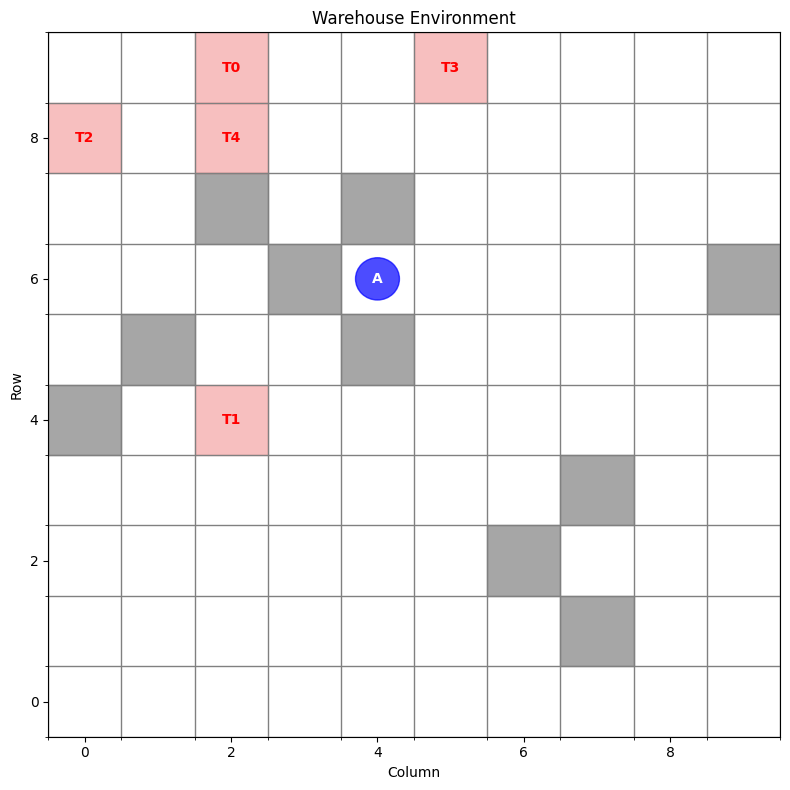

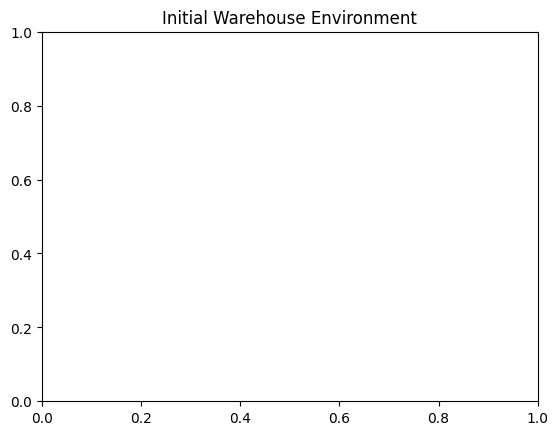

Running Rule-Based Agent simulation...
Episode: 100/1000, Success rate: 0.00%, Avg Steps: 201.00
Episode: 200/1000, Success rate: 0.00%, Avg Steps: 201.00
Episode: 300/1000, Success rate: 0.00%, Avg Steps: 201.00
Episode: 400/1000, Success rate: 0.00%, Avg Steps: 201.00
Episode: 500/1000, Success rate: 0.00%, Avg Steps: 201.00
Episode: 600/1000, Success rate: 0.00%, Avg Steps: 201.00
Episode: 700/1000, Success rate: 0.00%, Avg Steps: 201.00
Episode: 800/1000, Success rate: 0.00%, Avg Steps: 201.00
Episode: 900/1000, Success rate: 0.00%, Avg Steps: 201.00
Running DQN Agent simulation...


<ipython-input-3-ee224a55e622>:119: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  states = torch.FloatTensor([exp[0] for exp in batch])


Episode: 100/1000, Success rate: 6.00%, Avg Steps: 197.51
Episode: 200/1000, Success rate: 7.00%, Avg Steps: 196.15
Episode: 300/1000, Success rate: 4.00%, Avg Steps: 197.13
Episode: 400/1000, Success rate: 5.00%, Avg Steps: 195.86
Episode: 500/1000, Success rate: 2.00%, Avg Steps: 199.88
Episode: 600/1000, Success rate: 5.00%, Avg Steps: 197.84
Episode: 700/1000, Success rate: 6.00%, Avg Steps: 197.66
Episode: 800/1000, Success rate: 4.00%, Avg Steps: 197.53
Episode: 900/1000, Success rate: 5.00%, Avg Steps: 199.58


In [ ]:
# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

# Create environment
env = WarehouseEnvironment(grid_size=10, num_racks=10, num_targets=5)

# Display the initial environment
plt.figure(figsize=(8, 8))
env.render()
plt.title("Initial Warehouse Environment")
plt.show()

# Run simulations
print("Running Rule-Based Agent simulation...")
rule_based_metrics = run_simulation('rule_based', env, num_episodes=1000, render_interval=None)

print("Running DQN Agent simulation...")
dqn_metrics = run_simulation('dqn', env, num_episodes=1000, render_interval=None)



In [ ]:
# Analyze performance
rule_based_stats, dqn_stats = analyze_performance(rule_based_metrics, dqn_metrics)




Performance Comparison - Rule-Based vs DQN Agent

Performance Comparison - Rule-Based vs DQN Agent
                          Rule-Based         DQN  Difference   % Change
Metric                                                                 
Average Steps             201.000000  197.776000   -3.224000     -1.60%
Success Rate (%)            0.000000    4.600000    4.600000      +inf%
Average Orders Completed    1.823000    2.602000    0.779000    +42.73%
Average Reward           -180.947000 -164.834000   16.113000     -8.90%
Average Distance            6.991000   51.364000   44.373000   +634.72%
Median Steps              201.000000  201.000000    0.000000     +0.00%
Min Steps                 201.000000   35.000000 -166.000000    -82.59%
Max Steps                 201.000000  201.000000    0.000000     +0.00%
Average Time (s)            0.010139    0.588034    0.577895  +5699.84%

Percentage of episodes where all items were picked:
Rule-Based Agent: 0.00%
DQN Agent: 4.80%
Difference: +4

<ipython-input-6-6bb644902f59>:67: RuntimeWarning: divide by zero encountered in scalar divide
  percent_change = ((dqn_value / rule_based_value) - 1) * 100



Generating comparative visualizations...


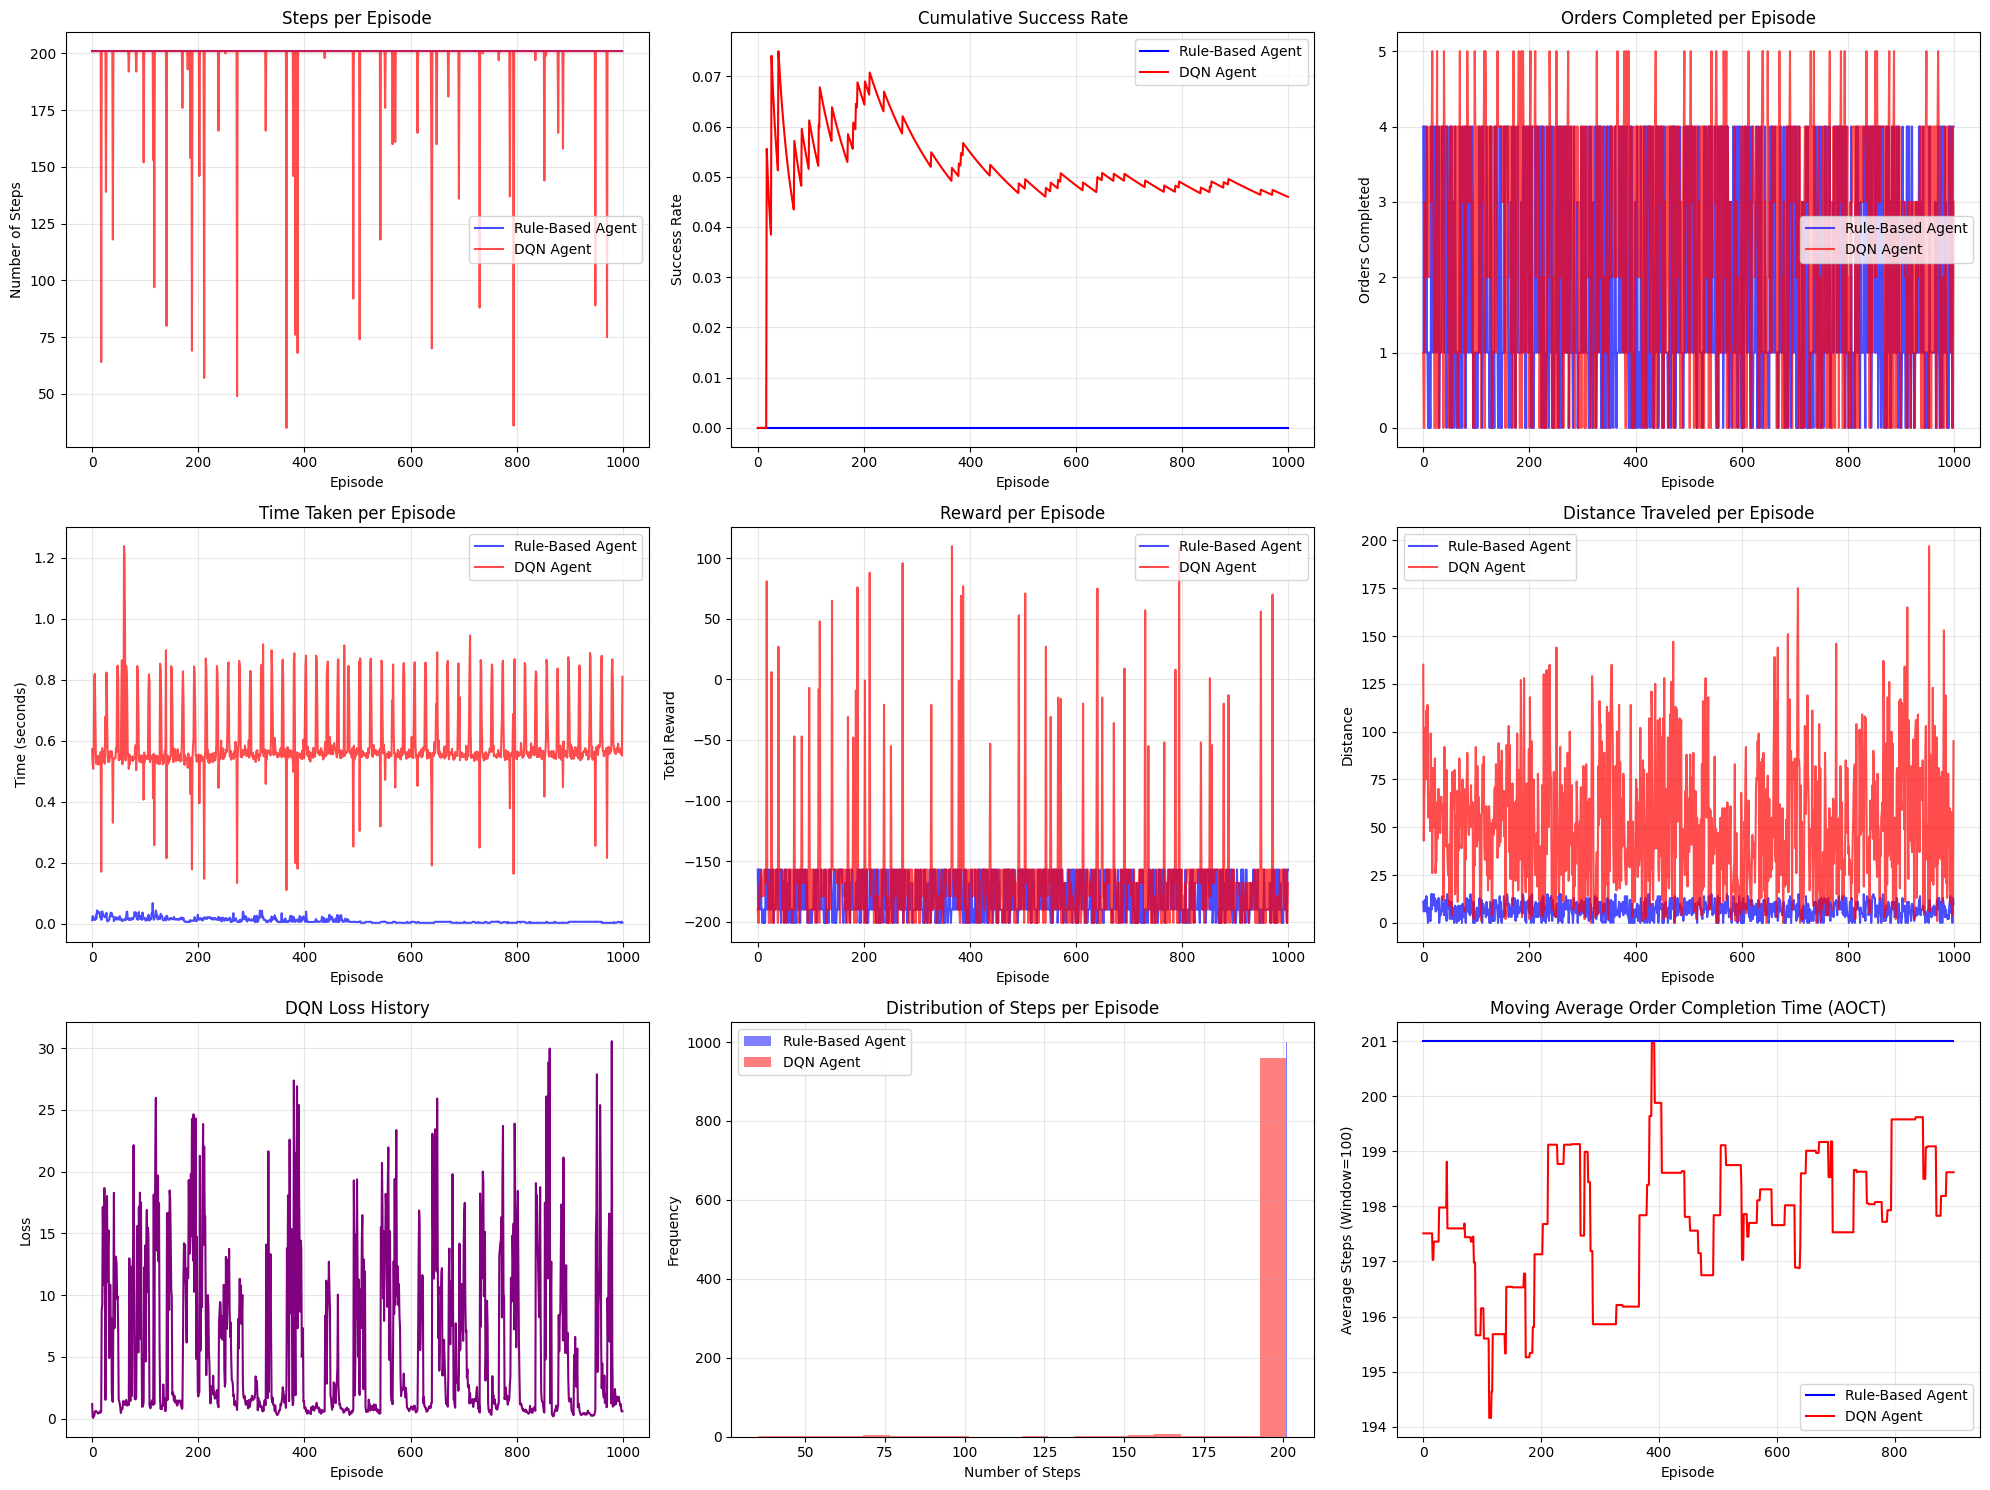

In [ ]:
# Plot comparative metrics
print("\nGenerating comparative visualizations...")
comparison_fig = plot_metrics_comparison(rule_based_metrics, dqn_metrics)
plt.show()





Creating animation of the trained agents...


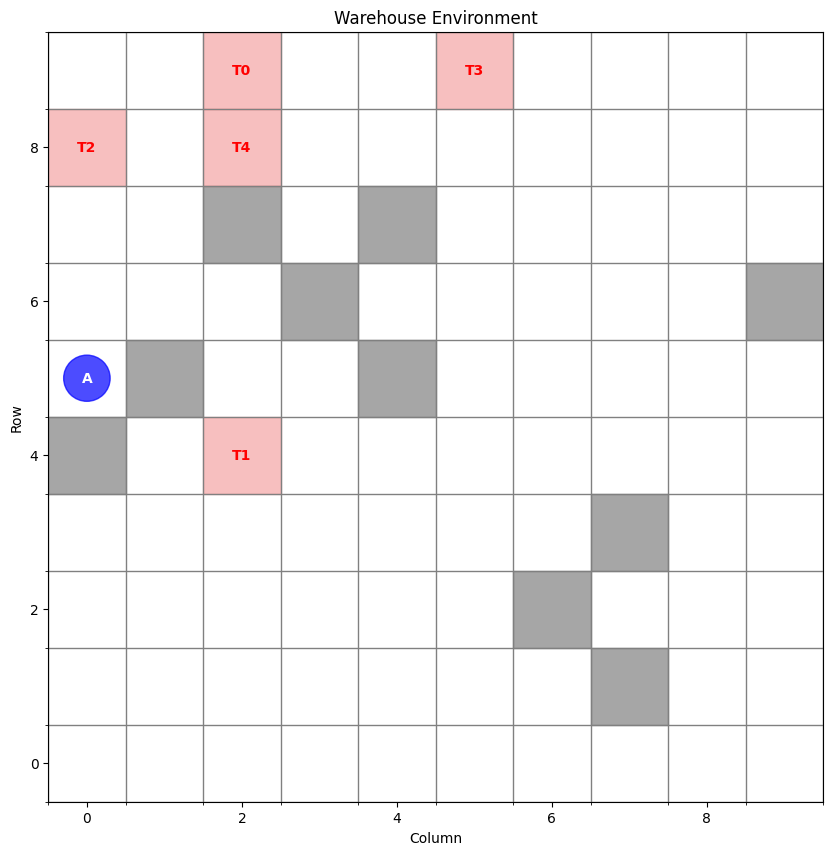

Rule-Based Agent Animation Ready


In [ ]:
# Create an agent for animation
print("\nCreating animation of the trained agents...")
# Rule-based agent
rule_based_agent = RuleBased()
rule_anim, rule_fig = create_warehouse_animation(env, rule_based_agent, 'rule_based', max_steps=100)
display(rule_fig)
print("Rule-Based Agent Animation Ready")



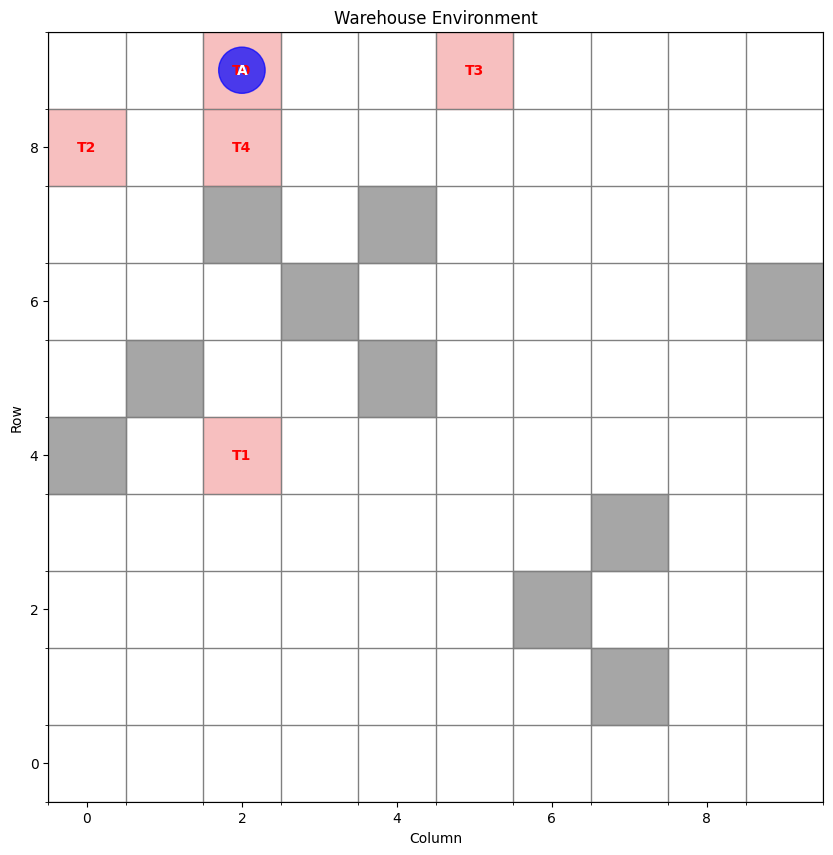

DQN Agent Animation Ready

Final Statistics:

Rule-Based Agent:
Average Steps: 201.00
Success Rate: 0.00%
Average Orders Completed: 1.82

DQN Agent:
Average Steps: 197.78
Success Rate: 4.60%
Average Orders Completed: 2.60


In [ ]:
# DQN agent
init_state = env.reset()
dqn_agent = DQNAgent(len(init_state), 4)
# Load trained weights if available or train a quick model
# (assuming we have a trained model from prior simulation)
dqn_anim, dqn_fig = create_warehouse_animation(env, dqn_agent, 'dqn', max_steps=100)
display(dqn_fig)
print("DQN Agent Animation Ready")

# Final statistics
print("\nFinal Statistics:")
print("\nRule-Based Agent:")
print(f"Average Steps: {rule_based_stats['avg_steps']:.2f}")
print(f"Success Rate: {rule_based_stats['success_rate']:.2f}%")
print(f"Average Orders Completed: {rule_based_stats['avg_orders']:.2f}")

print("\nDQN Agent:")
print(f"Average Steps: {dqn_stats['avg_steps']:.2f}")
print(f"Success Rate: {dqn_stats['success_rate']:.2f}%")
print(f"Average Orders Completed: {dqn_stats['avg_orders']:.2f}")

/usr/local/lib/python3.11/dist-packages/matplotlib/animation.py:908: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


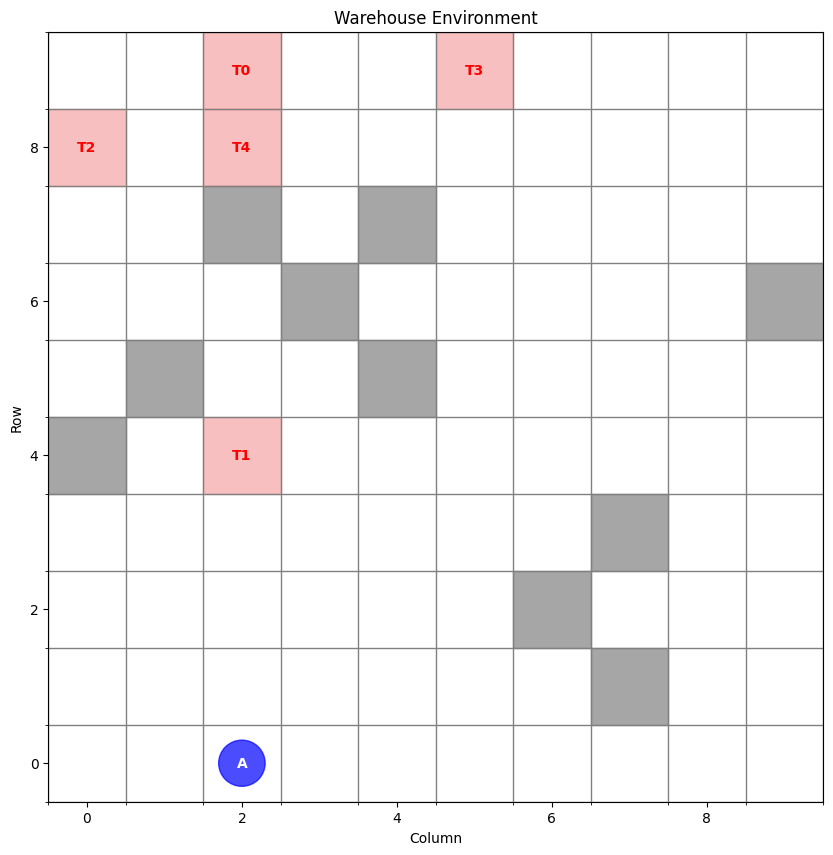

DQN Agent Animation Ready

Final Statistics:

Rule-Based Agent:
Average Steps: 201.00
Success Rate: 0.00%
Average Orders Completed: 1.82

DQN Agent:
Average Steps: 197.78
Success Rate: 4.60%
Average Orders Completed: 2.60


In [ ]:
# Load trained weights if available or train a quick model
# (assuming we have a trained model from prior simulation)
dqn_anim, dqn_fig = create_warehouse_animation(env, dqn_agent, 'dqn', max_steps=100)
display(dqn_fig)
print("DQN Agent Animation Ready")

# Final statistics
print("\nFinal Statistics:")
print("\nRule-Based Agent:")
print(f"Average Steps: {rule_based_stats['avg_steps']:.2f}")
print(f"Success Rate: {rule_based_stats['success_rate']:.2f}%")
print(f"Average Orders Completed: {rule_based_stats['avg_orders']:.2f}")

print("\nDQN Agent:")
print(f"Average Steps: {dqn_stats['avg_steps']:.2f}")
print(f"Success Rate: {dqn_stats['success_rate']:.2f}%")
print(f"Average Orders Completed: {dqn_stats['avg_orders']:.2f}")

## Additional Visualization:

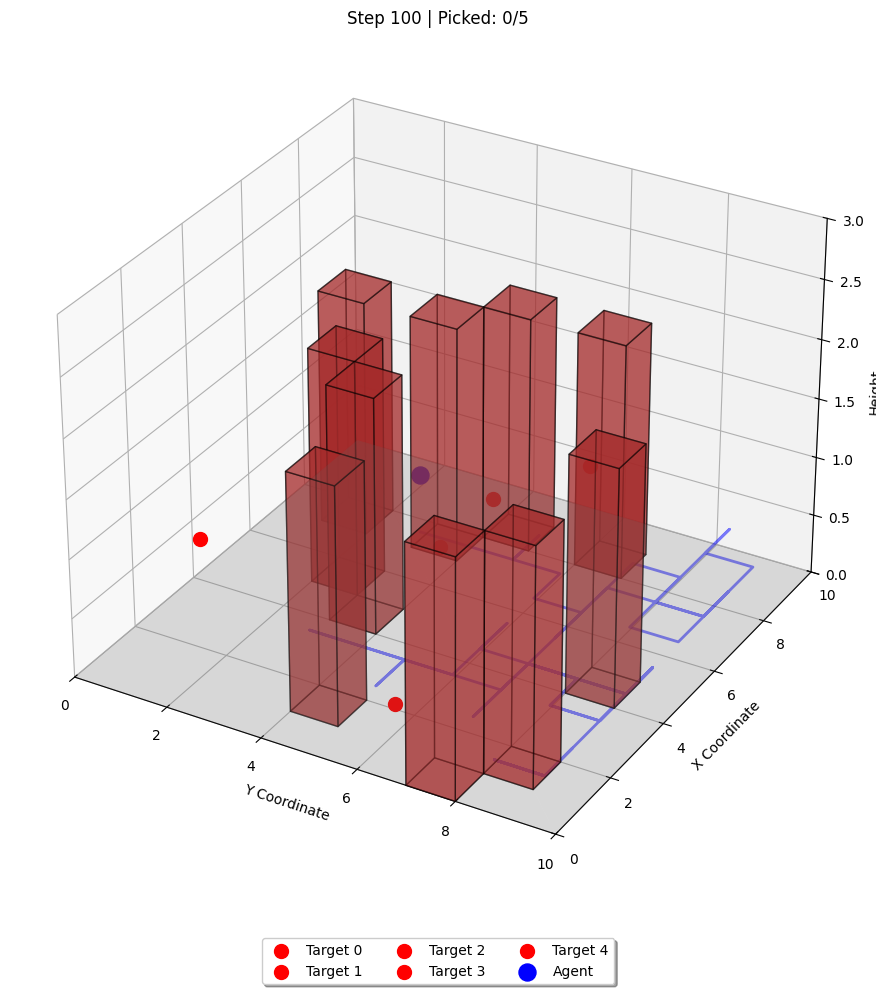

Maximum steps (100) reached without completion.


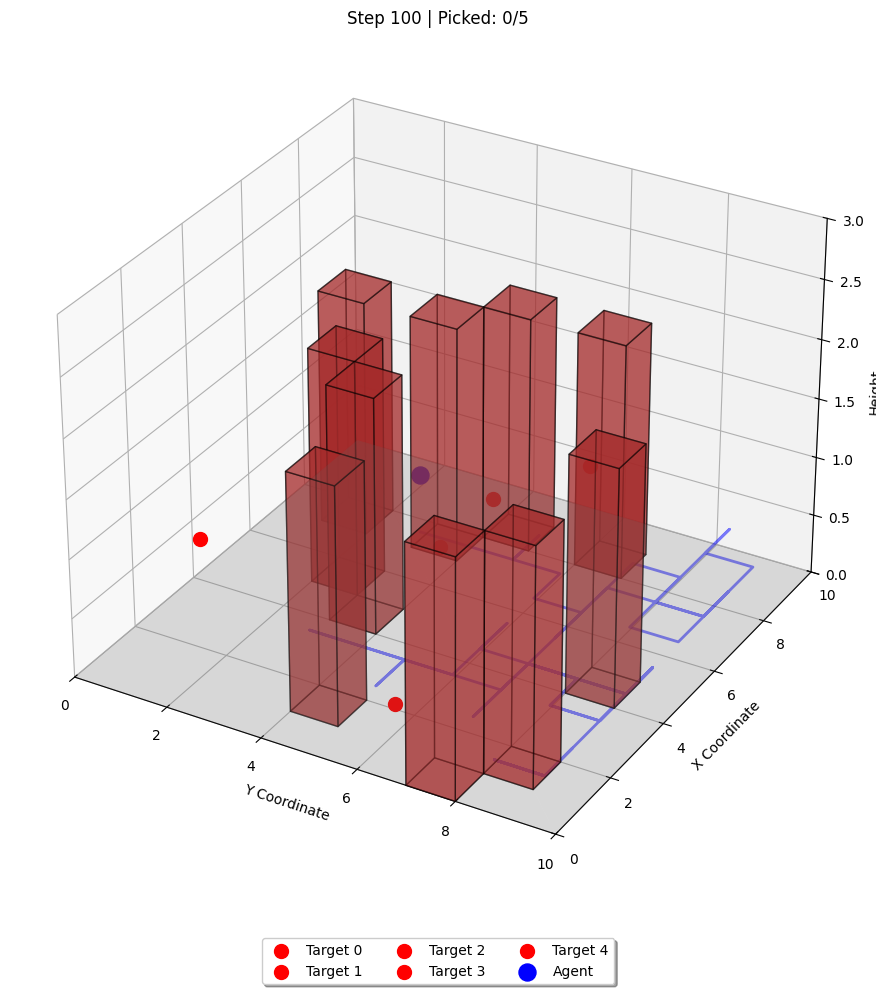

In [ ]:
# After running main()
env = WarehouseEnvironment()
init_state = env.reset()
dqn_agent = DQNAgent(len(init_state), 4)  # Create DQN agent

# Run additional analyses with DQN agent
compare_with_varying_parameters('num_targets', [3, 5, 7, 9])
analyze_reward_decomposition(env, dqn_agent, 'dqn')
create_3d_warehouse_simulation(env, dqn_agent, 'dqn')